In [1]:
import sqlite3
import pandas as pd

# Path to your SQLite database
db_path = "../youbike_data.db"

# Station ID to query
station_id = '500101027'  # Change this if you want another station

# SQL query
query = f"""
SELECT *
FROM 
    youbike_data
WHERE 
    sno = '{station_id}'
ORDER BY 
    mday ASC;
"""

# Connect to the database
conn = sqlite3.connect(db_path)

# Execute the query and load results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Check the first few rows
# df.head()

In [2]:
df.head()

,sno,sna,sarea,mday,ar,sareaen,snaen,aren,act,srcUpdateTime,updateTime,infoTime,infoDate,total,available_rent_bikes,latitude,longitude,available_return_bikes
0,500101027,YouBike2.0_臺灣科技大學後門,大安區,2024-11-18 12:26:14,基隆路四段41巷68弄臺科帆船大樓旁,Daan Dist.,YouBike2.0_NTUST(Back Gate),Aly. 68， Ln. 41， Sec. 4， Keelung Rd.,1,2024-11-18 12:28:23,2024-11-18 12:28:52,2024-11-18 12:26:14,2024-11-18,39,33,25.01182,121.54165,6
1,500101027,YouBike2.0_臺灣科技大學後門,大安區,2024-11-18 12:30:17,基隆路四段41巷68弄臺科帆船大樓旁,Daan Dist.,YouBike2.0_NTUST(Back Gate),Aly. 68， Ln. 41， Sec. 4， Keelung Rd.,1,2024-11-18 12:30:34,2024-11-18 12:30:52,2024-11-18 12:30:17,2024-11-18,39,30,25.01182,121.54165,9
2,500101027,YouBike2.0_臺灣科技大學後門,大安區,2024-11-18 12:35:16,基隆路四段41巷68弄臺科帆船大樓旁,Daan Dist.,YouBike2.0_NTUST(Back Gate),Aly. 68， Ln. 41， Sec. 4， Keelung Rd.,1,2024-11-18 12:35:23,2024-11-18 12:35:52,2024-11-18 12:35:16,2024-11-18,39,29,25.01182,121.54165,10
3,500101027,YouBike2.0_臺灣科技大學後門,大安區,2024-11-18 12:37:15,基隆路四段41巷68弄臺科帆船大樓旁,Daan Dist.,YouBike2.0_NTUST(Back Gate),Aly. 68， Ln. 41， Sec. 4， Keelung Rd.,1,2024-11-18 12:37:23,2024-11-18 12:37:52,2024-11-18 12:37:15,2024-11-18,39,28,25.01182,121.54165,11
4,500101027,YouBike2.0_臺灣科技大學後門,大安區,2024-11-18 12:39:15,基隆路四段41巷68弄臺科帆船大樓旁,Daan Dist.,YouBike2.0_NTUST(Back Gate),Aly. 68， Ln. 41， Sec. 4， Keelung Rd.,1,2024-11-18 12:39:22,2024-11-18 12:39:52,2024-11-18 12:39:15,2024-11-18,39,29,25.01182,121.54165,10


In [3]:
import pandas as pd
import numpy as np

# Use srcUpdateTime as datetime index
df['srcUpdateTime'] = pd.to_datetime(df['srcUpdateTime'])
df = df.sort_values('srcUpdateTime')
df = df.set_index('srcUpdateTime')

# Drop rows where available_rent_bikes is NaN
df = df.dropna(subset=['available_rent_bikes'])

# Optional: If you'd like to ensure hourly frequency, resample hourly
# and forward fill any missing slots (if that makes sense in your data)
# Adjust as needed based on the data granularity.
df = df.drop(columns=['sna', 'sarea', 'sareaen', 'snaen', 'ar', 'aren', 'mday', 'updateTime', 'infoTime', 'infoDate'], errors='ignore')
numeric_cols = df.select_dtypes(include=[float, int]).columns
df = df.resample('1H')[numeric_cols].mean().ffill()

# Add temporal features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Cyclical encoding of time features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

from sklearn.preprocessing import StandardScaler

# Separate features and target
target_col = 'available_rent_bikes'
feature_cols = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']  # for example

X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit and transform features
df[feature_cols] = X_scaler.fit_transform(df[feature_cols])

# Fit and transform target separately
df[[target_col]] = y_scaler.fit_transform(df[[target_col]])

# Now you can proceed with the sequence creation and modeling steps as previously outlined.


/tmp/ipykernel_556927/2809074366.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H')[numeric_cols].mean().ffill()


In [4]:
def create_sequences(df, target_col='available_rent_bikes', forecast_horizon=24):
    """
    Create sequences for each day: 
    Input: 48 hrs of data (24 hrs from previous day + 24 hrs from same weekday last week)
    Output: 24 hrs of the next day.
    """
    
    # Convert index to daily blocks. We must ensure continuous daily blocks.
    # Assuming data is hourly with no gaps:
    # We'll identify each unique date.
    df['date'] = df.index.date
    unique_dates = df['date'].unique()
    
    X, Y = [], []
    
    # We start from day i (skipping the first week + 1 day to have enough history)
    for i in range(7+1, len(unique_dates)):
        day = unique_dates[i]
        prev_day = unique_dates[i-1]
        week_before_day = unique_dates[i-7]
        
        # Extract the data for these days
        day_df = df[df['date'] == day]
        prev_day_df = df[df['date'] == prev_day]
        week_before_day_df = df[df['date'] == week_before_day]
        
        # We need exactly 24 hrs per day. If not exactly 24 rows, skip.
        if len(day_df) != 24 or len(prev_day_df) != 24 or len(week_before_day_df) != 24:
            continue
        
        # Inputs: concat previous day's 24 hours and week-before day's 24 hours
        input_sequence = pd.concat([prev_day_df, week_before_day_df], axis=0)
        
        # Output: next day (the current day) 24 hours of the target variable
        output_sequence = day_df[target_col].values
        
        # Select input features (except the target_col, or keep it if you want)
        # Let's assume we use all features except 'date'
        input_features = input_sequence.drop(columns=['date']).values
        
        X.append(input_features)
        Y.append(output_sequence)
    
    return np.array(X), np.array(Y)

In [5]:
import numpy as np

X, Y = create_sequences(df)
print("X shape:", X.shape)  # Expect (num_samples, 48 hours, number_of_features)
print("Y shape:", Y.shape)  # Expect (num_samples, 24)

# test train protocol
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]
Y_train = Y_train[..., np.newaxis] # Now shape (batch_size, 24, 1)
Y_test = Y_test[..., np.newaxis]



X shape: (22, 48, 13)
Y shape: (22, 24)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers

class PositionalEmbedding(layers.Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=d_model)

    def call(self, x):
        # x is shape (batch, sequence_length, d_model)
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        positions = self.pos_emb(positions)
        return x + positions

2024-12-18 14:49:13.436570: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 14:49:13.439470: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 14:49:13.448418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734504553.464340  556927 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734504553.468602  556927 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 14:49:13.483305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [7]:
def transformer_encoder(inputs, num_heads, dff, dropout=0.1):
    # Multi-head attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = layers.Dropout(dropout)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(inputs.shape[-1])
    ])
    ffn_output = ffn(out1)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return out2


In [8]:
input_seq_len = 48  # Example: 48 hours of input
num_features = X_train.shape[-1]
forecast_horizon = 24

d_model = 64        # Embedding size
num_heads = 4       # Multi-head attention heads
dff = 128           # Units in feed-forward layers
depth = 2           # Number of transformer encoder layers

inputs = layers.Input(shape=(input_seq_len, num_features))
# Project input features to d_model
x = layers.Dense(d_model)(inputs)  # Now x should have shape (None, 48, 64)

# Now apply positional embedding
x = PositionalEmbedding(maxlen=input_seq_len, d_model=d_model)(x)

for _ in range(depth):
    x = transformer_encoder(x, num_heads, dff)

# You can use a global pooling or just take the final sequence step 
# depending on your forecasting strategy. For forecasting next 24 hrs,
# consider a decoder or a simple Dense head that predicts all 24 steps at once.
# Here we assume a simple Dense output for all 24 hours at once:
x = layers.Flatten()(x)
outputs = layers.Dense(forecast_horizon)(x)
outputs = layers.Reshape((forecast_horizon, 1))(outputs)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


W0000 00:00:1734504554.983859  556927 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 48, 64)    │        896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 48, 64)    │      3,072 │ dense[0][0]       │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 64)    │     66,368 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 48, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 64)    │          0 │ positional_embed… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 48, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 48, 64)    │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 48, 64)    │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 48, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 48, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 48, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 48, 64)    │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 48, 64)    │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 48, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 244,120 (953.59 KB)

 Trainable params: 244,120 (953.59 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=20,
                    batch_size=32)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 4.6478 - mae: 1.7643 - val_loss: 2.6582 - val_mae: 1.3010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2.2008 - mae: 1.1836 - val_loss: 2.2203 - val_mae: 1.2019
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.6993 - mae: 1.0684 - val_loss: 2.1167 - val_mae: 1.2450
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.6314 - mae: 1.0550 - val_loss: 1.4813 - val_mae: 1.0150
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.4065 - mae: 0.9580 - val_loss: 1.1167 - val_mae: 0.8695
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.1358 - mae: 0.8659 - val_loss: 1.1698 - val_mae: 0.8981
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.3088 - mae: 0.9368 - val_loss: 1.2427 - val_mae: 0.9227
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.1936 - mae: 0.8822 - val_loss: 1.2932 - val_mae: 0.9494
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.1499 - mae: 0.8620 - va

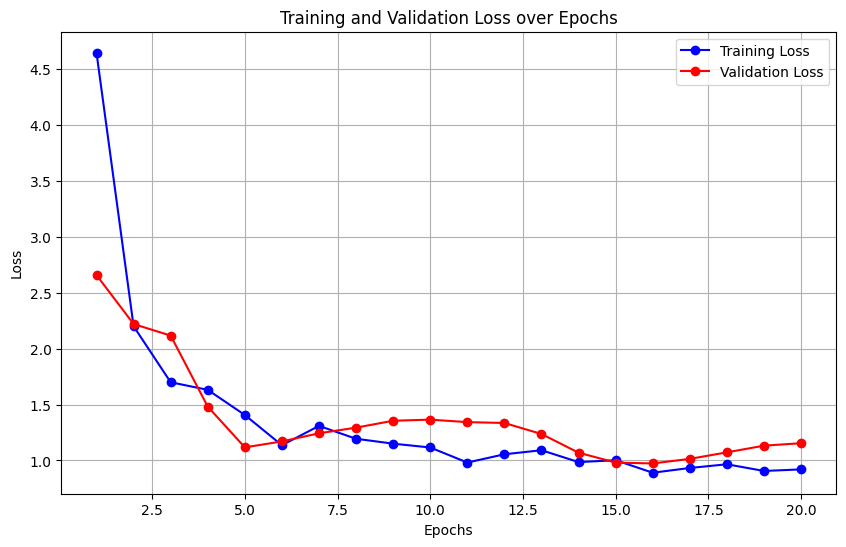

In [10]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
history_dict = history.history

# Extract losses
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


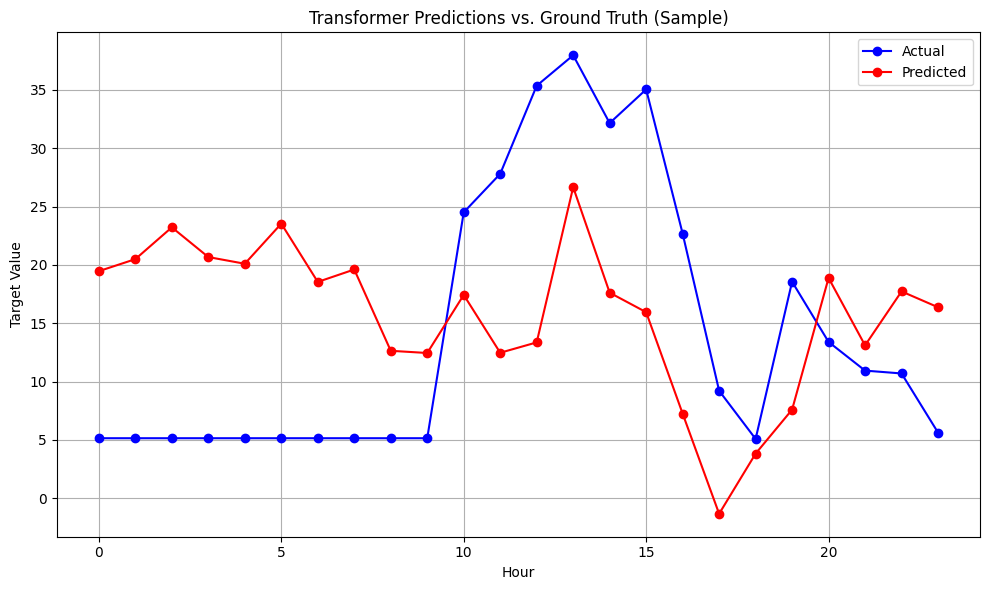

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)

# If your predictions and ground truth are scaled, invert the scaling
# This assumes Y was scaled in the same way as the features.
# If Y_test and y_pred are (batch, horizon, 1), reshape to (batch*horizon, 1) before inverse transform.
# y_pred is shape (samples, forecast_horizon, 1), reshape if needed:
y_pred_reshaped = y_pred.reshape(-1, 1)
y_test_reshaped = Y_test.reshape(-1, 1)

# Inverse transform just the target
y_pred_inverted = y_scaler.inverse_transform(y_pred_reshaped)
y_test_inverted = y_scaler.inverse_transform(y_test_reshaped)

# Reshape back to (samples, forecast_horizon)
y_pred_inverted = y_pred_inverted.reshape(-1, forecast_horizon)
y_test_inverted = y_test_inverted.reshape(-1, forecast_horizon)

# Let's pick a random sample from the test set to visualize
sample_idx = np.random.randint(0, len(X_test))
actual = y_test_inverted[sample_idx]
predicted = y_pred_inverted[sample_idx]

plt.figure(figsize=(10, 6))
plt.plot(range(forecast_horizon), actual, 'bo-', label='Actual')
plt.plot(range(forecast_horizon), predicted, 'ro-', label='Predicted')
plt.title('Transformer Predictions vs. Ground Truth (Sample)')
plt.xlabel('Hour')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Assuming you have:
# y_pred_inverted: your model's predictions in original scale
# y_test_inverted: the ground truth values in original scale

# Flatten if necessary (depends on your shape)
# For a multi-step forecast (e.g. forecast_horizon = 24), you may either:
# 1. Evaluate all horizons as a single vector:
y_pred_flat = y_pred_inverted.flatten()
y_test_flat = y_test_inverted.flatten()

# 2. Or evaluate metrics per horizon step:
# For example:
# mae_per_step = [mean_absolute_error(y_test_inverted[:, i], y_pred_inverted[:, i]) for i in range(forecast_horizon)]
# mse_per_step = [mean_squared_error(y_test_inverted[:, i], y_pred_inverted[:, i]) for i in range(forecast_horizon)]

# Overall metrics (across all forecasted points)
mae = mean_absolute_error(y_test_flat, y_pred_flat)
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = mse**0.5
mape = mean_absolute_percentage_error(y_test_flat, y_pred_flat)
r2 = r2_score(y_test_flat, y_pred_flat)


print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3%}")
print(f"R²: {r2:.3f}")



MAE: 11.198
MSE: 153.981
RMSE: 12.409
MAPE: 192.539%


In [21]:
df.describe()

,act,total,available_rent_bikes,latitude,longitude,available_return_bikes,hour,day_of_week,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos
count,723.0,723.0,7.230000e+02,7.230000e+02,7.230000e+02,723.000000,723.000000,723.000000,723.000000,723.000000,7.230000e+02,7.230000e+02,7.230000e+02
mean,1.0,39.0,1.965540e-17,2.501182e+01,1.215417e+02,24.051692,11.506224,2.863071,0.265560,0.000000,-4.422465e-17,6.142313e-17,1.277601e-16
std,0.0,0.0,1.000692e+00,3.832051e-15,2.872517e-14,11.888210,6.913466,2.001884,0.441937,1.000692,1.000692e+00,1.000692e+00,1.000692e+00
min,1.0,39.0,-1.211163e+00,2.501182e+01,1.215416e+02,0.000000,0.000000,0.000000,0.000000,-1.415048,-1.406396e+00,-1.440313e+00,-1.328112e+00
25%,1.0,39.0,-8.076291e-01,2.501182e+01,1.215417e+02,13.477273,6.000000,1.000000,0.000000,-1.000155,-9.928526e-01,-1.167942e+00,-1.328112e+00
50%,1.0,39.0,-3.438627e-01,2.501182e+01,1.215417e+02,28.282051,12.000000,3.000000,0.000000,0.001487,5.530440e-03,-6.513819e-02,-3.630201e-01
75%,1.0,39.0,9.142839e-01,2.501182e+01,1.215417e+02,33.857143,17.000000,5.000000,1.000000,1.003128,1.003913e+00,1.037666e+00,8.404305e-01
max,1.0,39.0,2.108946e+00,2.501182e+01,1.215417e+02,38.464286,23.000000,6.000000,1.000000,1.418022,1.417457e+00,1.310036e+00,1.376016e+00
